# Main analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [16]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'
xkeys_plt = [  # Input parameters
    Label.P, 
    Label.DC,
    Label.ISPTA
]

### Derived parameters

In [17]:
# Get batch-related settings
_, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, None, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'
figs_suffix = f'{figs_suffix}_{errprop}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/01/30 09:32:57: assembling batch analysis settings...
 2024/01/30 09:32:57: main analysis notebook started on 2024-01-30 at 09:32:57


### Input summary table figure

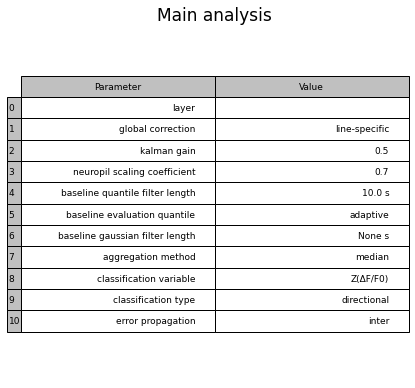

In [18]:
figs['dataset_info'] = plot_table({
    'layer': layer,
    'global correction': 'line-specific' if isinstance(global_correction, dict) else global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Main analysis', aspect=1.5)

### Load data

In [25]:
stats, counts = load_lineagg_data(input_dir, errprop=errprop)
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats_all = stats[isall].droplevel(Label.ROI_RESP_TYPE)
stats_by_rtype = stats[~isall]
stats_pos = stats_by_rtype.loc[pd.IndexSlice[:, 'positive', :]]

 2024/01/30 10:23:27: loading line-average data (with inter-propagated SE)
 2024/01/30 10:23:27: loading line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/01/30 10:23:27: loading sst data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/01/30 10:23:27: loading pv data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main folder
 2024/01/30 10:23:27: loading sarah_line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V

### Plot responder type distribution per mouse line

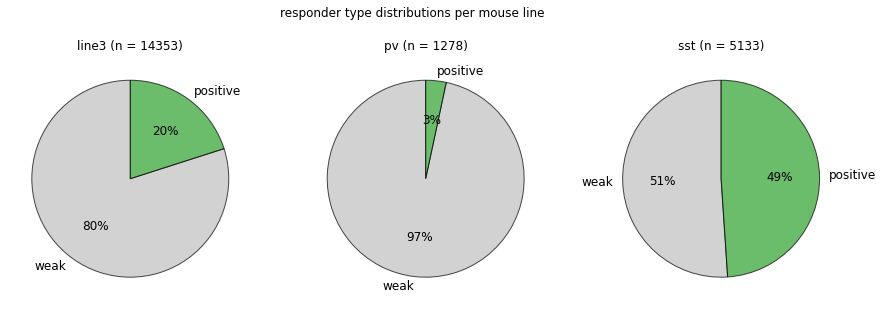

In [26]:
# Plot counts on pie chart
groups = stats_by_rtype.groupby(Label.LINE)
naxes = len(groups)
figs['rtype_dist_per_line'], axes = plt.subplots(1, naxes, figsize=(5 * naxes, 5))
axes = np.atleast_1d(axes)
figs['rtype_dist_per_line'].set_facecolor('w')
figs['rtype_dist_per_line'].suptitle('responder type distributions per mouse line')
for ax, (line, gdata) in zip(axes, groups):
    counts_by_rtype = (gdata['count']
        .groupby(Label.ROI_RESP_TYPE)
        .first()
        .reindex(get_default_rtypes())
        .dropna()
    )
    ax.set_title(f'{line} (n = {counts[line].sum()})')
    counts_by_rtype.plot.pie(
        ax=ax, 
        ylabel='',
        autopct='%1.0f%%',
        colors=[Palette.RTYPE[k] for k in counts_by_rtype.index],
        startangle=90, 
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'k', 'alpha': 0.7}
    )

### Plot P, DC and Ispta parameter dependency curves, with fits

In [32]:
fit_dict = get_fit_table(Pfit='scaled_power')

 2024/01/30 10:45:02: plotting evoked ΔF/F0 change vs. P (MPa) dependency profile for line3 line
 2024/01/30 10:45:02: computing fit with scaled_power function: p0 = [0.042, 1]
 2024/01/30 10:45:02: fitting results: popt = [0.049, 1.8], R2 = 0.96
 2024/01/30 10:45:02: plotting evoked ΔF/F0 change vs. P (MPa) dependency profile for pv line
 2024/01/30 10:45:02: computing fit with scaled_power function: p0 = [0.0021, 1]
 2024/01/30 10:45:02: fitting results: popt = [0.00093, 1.3e-07], R2 = 0.29
 2024/01/30 10:45:02: plotting evoked ΔF/F0 change vs. P (MPa) dependency profile for sst line
 2024/01/30 10:45:02: computing fit with scaled_power function: p0 = [0.14, 1]
 2024/01/30 10:45:02: fitting results: popt = [0.22, 3.1], R2 = 0.99
 2024/01/30 10:45:02: plotting evoked ΔF/F0 change vs. DC (%) dependency profile for line3 line
 2024/01/30 10:45:02: computing fit with sigmoid function: p0 = [37, 40, 0.034]
 2024/01/30 10:45:02: fitting results: popt = [25, 9.6, 0.028], R2 = 0.92
 2024/01/

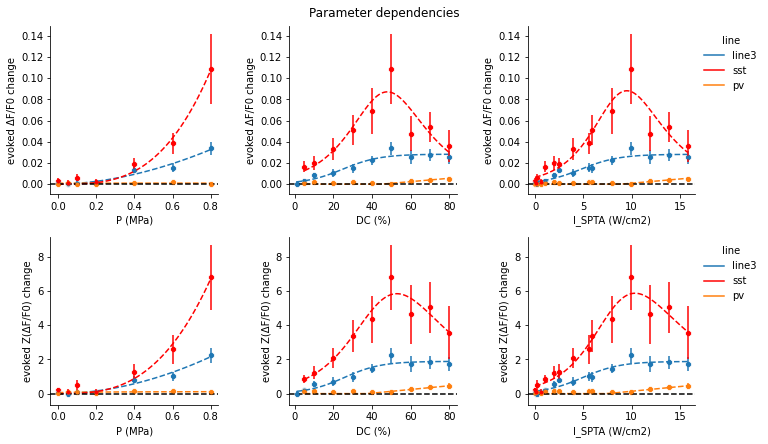

In [35]:
# Independent parameters
xkeys = [
    Label.P,
    Label.DC,
    Label.ISPTA,
]

# Dependent response variables
ykeys = [
    get_change_key(Label.DFF),
    get_change_key(Label.ZSCORE),
    # Label.RESP_FRAC,
]

figs[f'simparams_deps'] = plot_parameter_dependency_across_lines(
    stats_all.copy(),
    xkeys,
    ykeys,
    lw=0,
    marker='o',
    err_style='bars',
    fit=fit_dict,
    # fit_ci=0.67,
    # norm=True,
)
figs[f'simparams_deps'].suptitle('Parameter dependencies', y=1.02);

### Plot P - DC alignment for various dose projections, for each mouse line

 2024/01/30 10:24:20: Processing line3 line
 2024/01/30 10:24:20: computing fit with sigmoid function: p0 = [0.27, 0.32, 0.034]
 2024/01/30 10:24:20: fitting results: popt = [0.2, 0.076, 0.028], R2 = 0.93
 2024/01/30 10:24:20: computing fit with sigmoid function: p0 = [6.6, 7.9, 0.034]
 2024/01/30 10:24:20: fitting results: popt = [4.9, 1.9, 0.028], R2 = 0.93
 2024/01/30 10:24:20: computing fit with sigmoid function: p0 = [8.5, 7.7, 0.034]
 2024/01/30 10:24:20: fitting results: popt = [8.4, 2, 0.029], R2 = 0.92
 2024/01/30 10:24:20: Processing pv line
 2024/01/30 10:24:20: computing fit with delayed_linear function: p0 = [0.47, 0.03, 0.00064]
 2024/01/30 10:24:20: fitting results: popt = [0.36, 0.02, 0.0064], R2 = 0.61
 2024/01/30 10:24:20: accuracy exceeds reasonable range: 4.48e+13
 2024/01/30 10:24:20: computing fit with delayed_linear function: p0 = [12, 0.0012, 0.016]
 2024/01/30 10:24:20: fitting results: popt = [8.9, 0.0008, 0.0065], R2 = 0.61
 2024/01/30 10:24:20: accuracy exce

/gpfs/home/lemait01/.conda/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gpfs/home/lemait01/.conda/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 2024/01/30 10:24:21: fitting results: popt = [0.36, 15, 6.2, 0.17], R2 = 0.85
 2024/01/30 10:24:21: computing fit with sigmoid_decay function: p0 = [7.9, 0.11, 0.011, 0.11]
 2024/01/30 10:24:21: fitting results: popt = [8.9, 0.59, 0.25, 0.17], R2 = 0.85
 2024/01/30 10:24:21: computing fit with sigmoid_decay function: p0 = [11, 0.12, 0.012, 0.11]
 2024/01/30 10:24:21: fitting results: popt = [13, 0.91, 0.58, 0.16], R2 = 0.84


/gpfs/home/lemait01/.conda/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


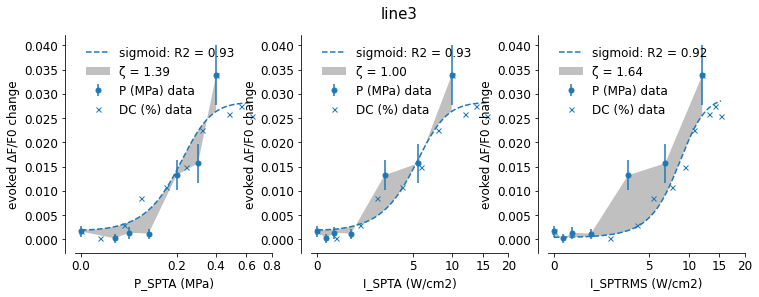

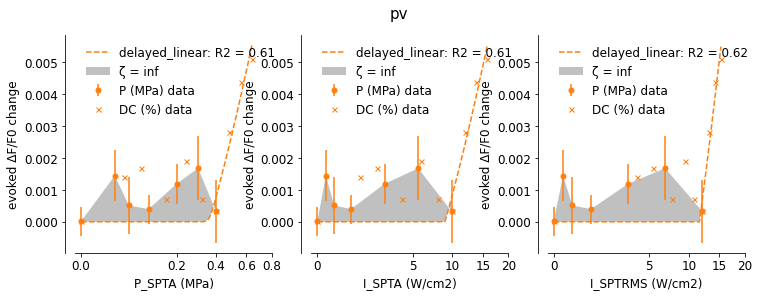

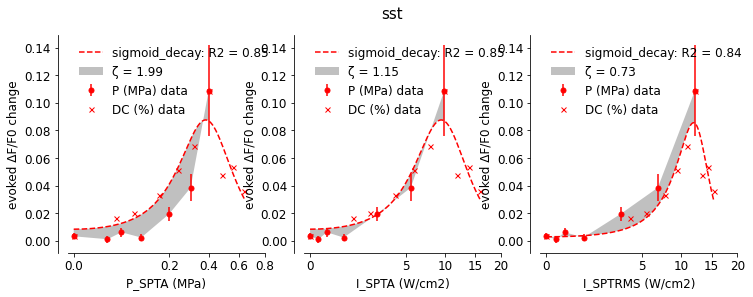

In [28]:
# Dose metrics
xkeys = [
    Label.PSPTA,
    Label.ISPTA,
    Label.ISPTRMS,
]

# Dependent response variables
fit_ykeys = [
    get_change_key(Label.DFF)
]

# For each line
for line, gstats in stats_all.groupby(Label.LINE):
    logger.info(f'Processing {line} line')
    # For each output metrics
    for ykey_diff in fit_ykeys:
        # Evaluate and plot alignment between DC sweep predictor and P sweep data
        figs[f'{line} {ykey_diff} fits'] = plot_response_alignment(
            gstats, 
            xkeys, 
            ykey_diff, 
            fit=get_fit_table()[line], 
            xscale='sqrt', 
            height=4,
            title=line,
        )

### Plot average cell density per line

 2024/01/30 10:25:31: computing cell densities from cell counts
 2024/01/30 10:25:31: plotting cell densities across lines


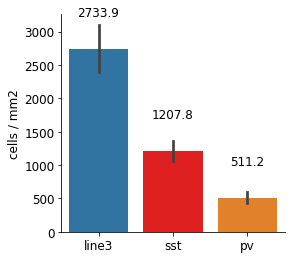

In [29]:
# Compute cell densities from cell counts
logger.info('computing cell densities from cell counts')
Lx = Ly = .5  # FOV dimensions (mm)
fov_area = Lx * Ly  # mm2
densities = (counts / fov_area).rename(Label.ROI_DENSITY)

# Plot average cell densities
logger.info('plotting cell densities across lines')
fs = 12
figs['cell densities'], ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
sns.barplot(
    data=densities.reset_index(), 
    ax=ax, 
    x=Label.LINE, 
    y=Label.ROI_DENSITY,
    palette=Palette.LINE,
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', fontsize=fs, padding=30)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fs)
ax.set_xlabel(None)
ax.set_ylabel(Label.ROI_DENSITY, fontsize=fs);

### Define E/I roles and factors for each cell type in the circuit

In [24]:
cellstats = densities.groupby(Label.LINE).mean().to_frame()
cellstats['factor'] = cellstats[Label.ROI_DENSITY] / cellstats[Label.ROI_DENSITY].max()
cellstats['type'] = {
    'line3': 'E',
    'sst': 'I',
    'pv': 'I',
}
cellstats['sign'] = cellstats['type'].map({'E': 1, 'I': -1})
cellstats['prefix'] = cellstats['type'].map({'E': '+', 'I': '-'})
cellstats

,cells / mm2,factor,type,sign,prefix
line,,,,,
line3,2653.400000,1.000000,E,1,+
pv,363.555556,0.137015,I,-1,-
sst,967.529412,0.364638,I,-1,-


### Plot nominal and scaled responses per mouse line, and net circuit effect

 2023/11/08 09:28:39: extracting, computing, and scaling line3 responses
 2023/11/08 09:28:39: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2023/11/08 09:28:39: computing fit with sigmoid function: p0 = [5.1, 7.9, 0.015]
 2023/11/08 09:28:39: fitting results: popt = [5.1, 1.9, 0.012], R2 = 0.91
 2023/11/08 09:28:39: fit parameter standard errors: [0.69, 0.48, 0.00099]
 2023/11/08 09:28:39: computing fit uncertainty with 1000 Monte Carlo simulations
 2023/11/08 09:28:39: extracting, computing, and scaling pv responses
 2023/11/08 09:28:39: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2023/11/08 09:28:39: computing fit with sigmoid function: p0 = [5.4, 7.9, 0.006]
 2023/11/08 09:28:39: Failed to fit pv data: convergence error during fitting
 2023/11/08 09:28:39: extracting, computing, and scaling sst responses
 2023/11/08 09:28:39: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2023/11/08 09:28:39: computing fit with sigmoid function: p0 =

/gpfs/home/lemait01/.conda/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gpfs/home/lemait01/.conda/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/gpfs/data/shohamlab/theo/code/usnm2p/utils.py:833: RuntimeWarning: overflow encountered in exp
  norm_sig = 1 / (1 + np.exp(-(x - x0) / sigma))


 2023/11/08 09:28:40: extracting, computing, and scaling line3 responses
 2023/11/08 09:28:40: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2023/11/08 09:28:40: computing fit with sigmoid function: p0 = [5.1, 7.9, 0.96]
 2023/11/08 09:28:40: fitting results: popt = [5.3, 2, 0.82], R2 = 0.92
 2023/11/08 09:28:40: fit parameter standard errors: [0.68, 0.48, 0.065]
 2023/11/08 09:28:40: computing fit uncertainty with 1000 Monte Carlo simulations
 2023/11/08 09:28:40: extracting, computing, and scaling pv responses
 2023/11/08 09:28:40: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2023/11/08 09:28:40: computing fit with sigmoid function: p0 = [5.4, 7.9, 0.47]
 2023/11/08 09:28:40: fitting results: popt = [0.43, 3, 0.15], R2 = 0.02
 2023/11/08 09:28:40: Failed to fit pv data: unreliable fit (R2 = 0.02 > 0.50)
 2023/11/08 09:28:40: extracting, computing, and scaling sst responses
 2023/11/08 09:28:40: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filter

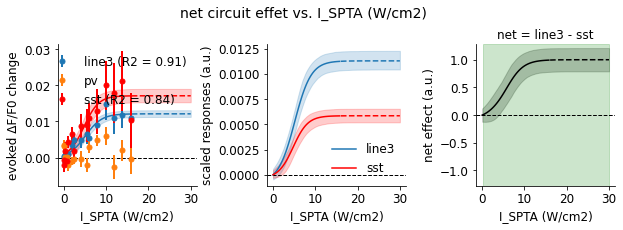

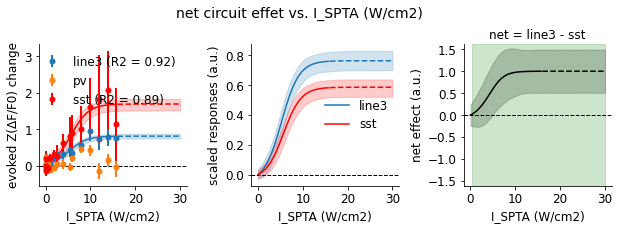

In [25]:
# Input parameter and its max value
xkey = Label.ISPTA
xmax = 30.

# Dependent response variables
ykeys = [
    get_change_key(Label.DFF), 
    get_change_key(Label.ZSCORE)
]

# For each response variable, plot circuit effect
for ykey in ykeys:
    figs[f'net_effect_{ykey}'] = plot_circuit_effect(
        stats_all, 
        cellstats, 
        xkey, 
        ykey, 
        ci=.67,
        xmax=xmax,
        fit='sigmoid',
        add_net_color=True,
    )

### Save figures

In [26]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 2023/11/08 09:28:42: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2023.11.08/figs_main_all_linreg_nointercept_qmaxadaptive_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional_inter.pdf:


100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


### Notify upon completion

In [27]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'main analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2023/11/08 09:28:47: main analysis notebook completed in 0:00:27.988004 s
